## Strategy Idea 1 : "BSP Hedging"

__Section 0: Setup__ Importing packages/reading in data etc.

__Section 1 : Idea__ 

- __1.1__ Strategy idea

- __1.2__ Origin of idea. Context/Reasoning for strategy to work e.g. use in financial markets?

__Section 2 : Exploration__

- __2.1__ Exploratory Data Analysis. e.g plots of price/volumes that could show strategy working, how much potential.

- __2.2__ Define some 'strategy metrics'. Metrics that can can you use to gauge if this strategy will work i.e no.price points above a certain threshold that is profitable. Metrics could show how often there is an opportunity to make a trade and how much 'value' is in an opportunity e.g. how much is there a price swing?

__Section 3 : Practical requirements__

- __3.1__ Identify if this edge is ‘realisable’? What methods will you apply to extract this value? e.g. applying a hedge function


- __3.2__ Is it possible to quantify the potential profit from the strategy? Consideration : How long will it take to obtain this? How 'risky' is it? e.g. if something did go wrong, how much do we lose? 

- __3.3__ Strategy limitations. The factors that could prevent strategy working e.g. practical considerations e.g. reacting quick enough to market updates, volume behind a price, size of bankroll needed


__Section 4: Potential limitations__

- __4.1__ What is our 'competition' - if not quantifiable, do we suspect people are doing the same thing? 

- __4.2__ So what's our edge? Identify ways of finding this edge in future? e.g what features are there? Are they predictive? Is there a certain 'market/runner' profile?

__Section 5 : Strategy testing__

- __5.1__ Testing strategy on previous data. 

- __5.2__ State any assumptions made by testing.

- __5.3__ Model refinements. How could strategy be optimised? Careful : is this backfitting/overfitting - what measures taken to negate this e.g. bootstrapping?

- __5.4__ Assessing strategy. P/L on data sample? ROI? variance in results? longest losing run?



### Section 0 : Setup

In [1]:
# importing packages
from pathlib import Path, PurePath 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# reading in data
project_dir = Path.cwd().parents[2]
data_dir = f"{project_dir}/data/processed/api/advanced/adv_data.csv"
df = pd.read_csv(data_dir, index_col = 0)

In [101]:
# defining variables
back_prices = [col for col in df.columns if 'BP' in col]
back_sizes = [col for col in df.columns if 'BS' in col]
lay_prices = [col for col in df.columns if 'LP' in col]
lay_sizes = [col for col in df.columns if 'LS' in col]
runner_info = ['SelectionId', 'MarketId', 'Venue', 'Distance', 'RaceType', 'BSP', 'NoRunners']

### Section 1 : Idea

__1.1 Idea__

There is a large amount of price variation during __inplay__ markets in addition to high volumes of trading with £100,000-£200,000 (~20% of total matched per race) occurring during a race. I believe there is a profitable strategy to be had in back/laying a horse 'simultaneously at BSP and looking the 'hedge' this during a race. 

For example, backing a horse at BSP laying it higher inplay as well as laying at BSP and backing whilst inplay. Both yielding profitable hedge bets. Due to the amount of variation and the frequency at which this occurs (seems to be for large & of runners) with inplay prices, I suspect that there there is a large amount of potential to exploit this.

__1.2  Reasoning__

Why is there an edge here?
- Variation caused by a events that can happen within horse racing - anything can happen -> variations. e.g. a leader out in front all the way who then falls or a really close race where anyone can win it -> many price swings!
- Due to this in race 'unpredicatability' I believe there is a large amount of uncertainty of what the actua; price point is during the race, whilst the market price's the end result of the race as if it is 'easily estimated' but the minimum inplay overround ' says otherwise, meaning the inplay markets are very ineeficient. 

_Minimum Inplay overround : Taking the minimum price for every runner during a race and calculating the overround. There is a very high amount of overround 2X/3X that of a 'pre-race' market. Revealing that many runners in play are clearly priced inefficiently i.e. price != probability of winning the race._ High inplay overround/inefficiency has been identified in the `strategy_tests_old` notebooks.

### Section 2 : Exploration

__2.1__ Plots

To explore this phenomena (of price variation in comparison to BSP) plots of the back price and lay price throughout the time of race are shown below: 

__Back Prices by Market__

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text major ticklabel objects>)

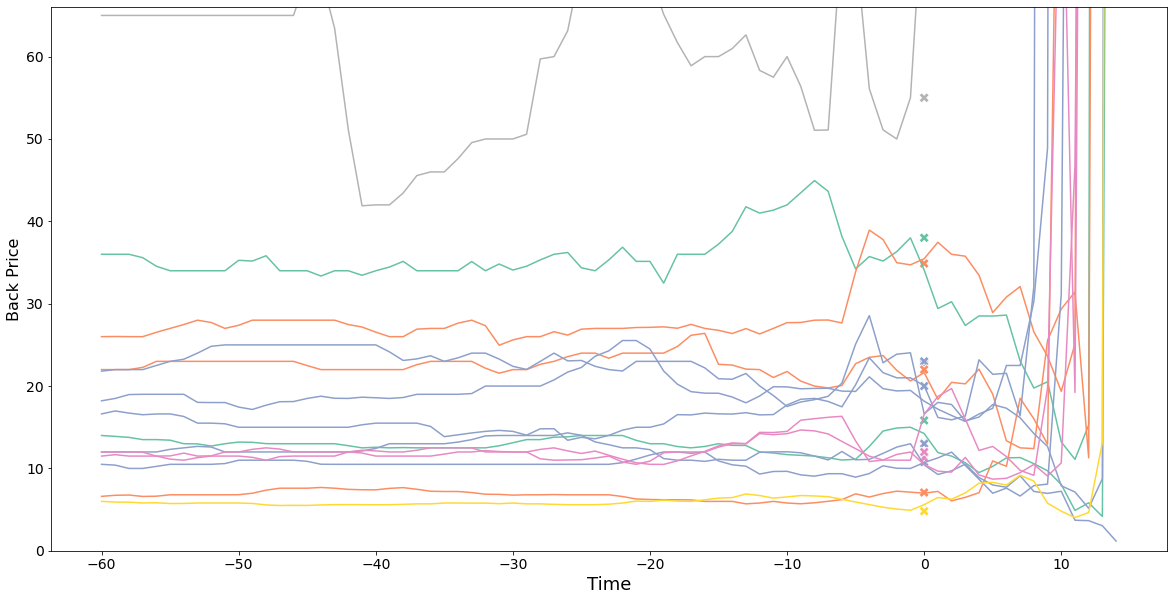

In [139]:
# list all market ids in sample
mids = df['MarketId'].unique()

# choose index of a market id to plot 
i = 5

# create plotting dataframe - MOVE THIS DF PROCESSING FURTHER UP?
plot_df = df.loc[df['MarketId'].isin(mids[i:i+1])][['SelectionId']+back_prices].copy()
sep_df = df.loc[df['MarketId'].isin(mids[i:i+1])][['BSP', 'SelectionId']].copy()
plot_df.columns = plot_df.columns.str.replace("[BP:T]", "")
plot_df.columns = plot_df.columns.str.replace("[+]", "")
plot_df = pd.melt(plot_df, id_vars = ['SelectionId'])
plot_df['variable'] = plot_df['variable'].astype(int)

# set plotting parameters
plt.figure(figsize=(20,10))
plt.ylim(0, sep_df['BSP'].max() * 1.2) # limit y axis


# plotting
sns.scatterplot(np.zeros(sep_df['SelectionId'].nunique()), y = sep_df['BSP'],
                hue = sep_df['SelectionId'], palette = 'Set2', legend = False,
                marker = 'X', s=100)
sns.lineplot(x = 'variable', y = 'value',
             hue = 'SelectionId', data = plot_df, ci = None,
             palette = 'Set2', legend = False)

# plot formatting
plt.xlabel('Time', fontsize=18)
plt.ylabel('Back Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

__Lay Prices by Market__

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text major ticklabel objects>)

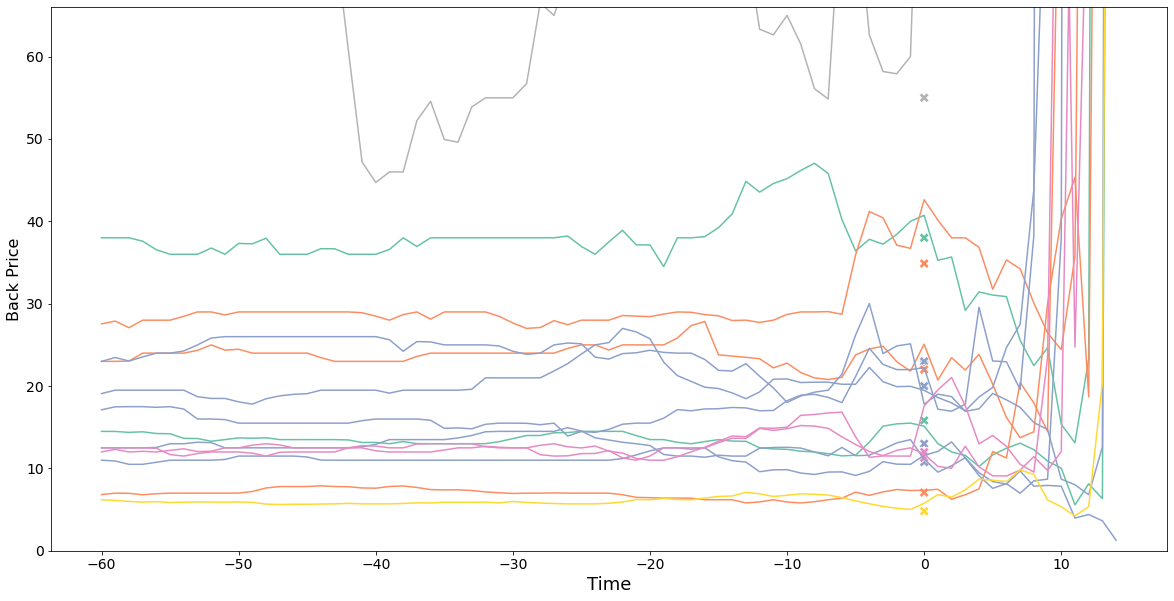

In [141]:
# list all market ids in sample
mids = df['MarketId'].unique()

# choose index of a market id to plot 
i = 5

# create plotting dataframe
plot_df = df.loc[df['MarketId'].isin(mids[i:i+1])][['SelectionId']+lay_prices].copy()
sep_df = df.loc[df['MarketId'].isin(mids[i:i+1])][['BSP', 'SelectionId']].copy()
plot_df.columns = plot_df.columns.str.replace("[LP:T]", "")
plot_df.columns = plot_df.columns.str.replace("[+]", "")
plot_df = pd.melt(plot_df, id_vars = ['SelectionId'])
plot_df['variable'] = plot_df['variable'].astype(int)

# set plotting parameters
plt.figure(figsize=(20,10))
plt.ylim(0, sep_df['BSP'].max() * 1.2) # limit y axis


# plotting
sns.scatterplot(np.zeros(sep_df['SelectionId'].nunique()), y = sep_df['BSP'],
                hue = sep_df['SelectionId'], palette = 'Set2', legend = False,
                marker = 'X', s=100)
sns.lineplot(x = 'variable', y = 'value',
             hue = 'SelectionId', data = plot_df, ci = None,
             palette = 'Set2', legend = False)

# plot formatting
plt.xlabel('Time', fontsize=18)
plt.ylabel('Back Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

__Back & Lay by Selection__

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 <a list of 9 Text major ticklabel objects>)

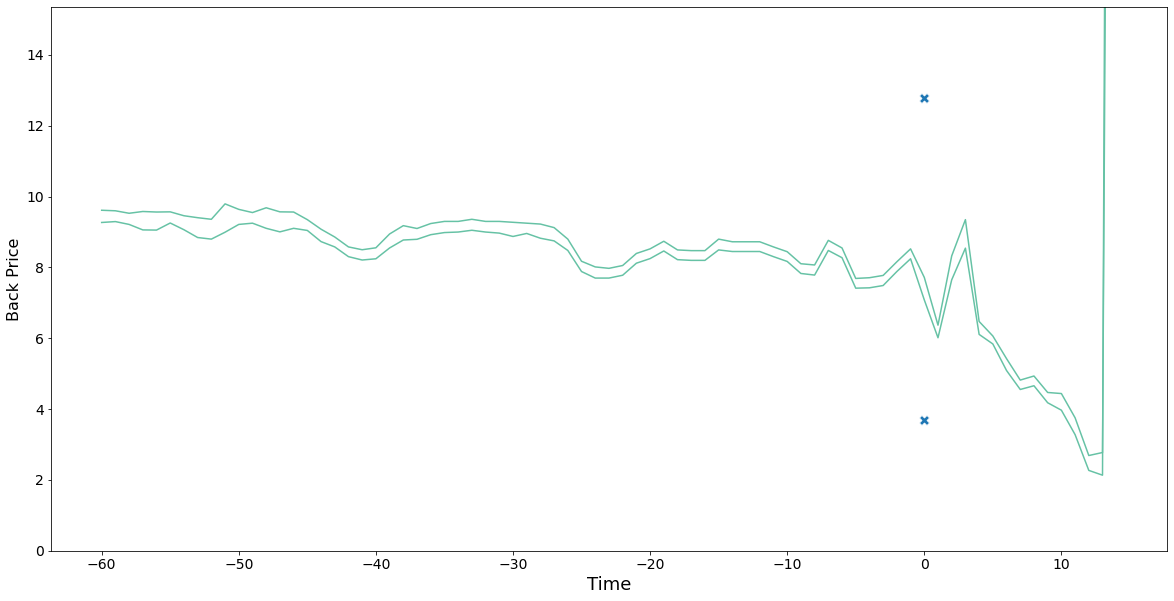

In [149]:
sids = df['SelectionId'].unique()
i = 1

bp_df = df.loc[df['SelectionId'].isin(sids[i:i+1])][['SelectionId']+back_prices].copy()
bp_df.columns = bp_df.columns.str.replace("[BP:T]", "")
bp_df.columns = bp_df.columns.str.replace("[+]", "")
bp_df = pd.melt(bp_df, id_vars = ['SelectionId'])
bp_df['variable'] = bp_df['variable'].astype(int)

lp_df = df.loc[df['SelectionId'].isin(sids[i:i+1])][['SelectionId']+lay_prices].copy()
lp_df.columns = lp_df.columns.str.replace("[LP:T]", "")
lp_df.columns = lp_df.columns.str.replace("[+]", "")
lp_df = pd.melt(lp_df, id_vars = ['SelectionId'])
lp_df['variable'] = lp_df['variable'].astype(int)

bsp_df = df.loc[df['SelectionId'].isin(sids[i:i+1])][['BSP', 'SelectionId']].copy()

# set plotting parameters
plt.figure(figsize=(20,10))
plt.ylim(0, sep_df['BSP'].max() * 1.2) # limit y axis


# plotting
sns.scatterplot(0, y = bsp_df['BSP'],legend = False,marker = 'X', s=100)

sns.lineplot(x = 'variable', y = 'value',
             hue = 'SelectionId', data = lp_df, ci = None,
             palette = 'Set2', legend = False)

sns.lineplot(x = 'variable', y = 'value',
             hue = 'SelectionId', data = bp_df, ci = None,
             palette = 'Set2', legend = False)

# plot formatting
plt.xlabel('Time', fontsize=18)
plt.ylabel('Back Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# why two BSP's ? 

In [148]:
sep_df # name this bsp_df and ahh yes of course a runner may appear more than once!!!

,BSP,SelectionId
1,3.68,16800725
0,12.79,16800725


In [ ]:
Metrics: 
- if inplay BP went above bsp? how many times per runner? how much higher does it go 'on average i guess'
- if inplay LP went below bsp? how mnay times per runner? how much higher does it go 'on average i guess'
- variance of inplay BP/LP per runner
    
Final metrics : 
B2L
- if BSP BP is higher than IP LP

L2B
- if BSP LP is lower than IP BP

L2B
    
BOTH
- (if BSP BP is higher than IP LP) & (if BSP LP is lower than IP BP)
- but then by how much ? higher than minhedge/maxhedge.

Then do the same but tih the max/min hedge price and if that is exceeded, then if volume is there behind it

Taking into account of course, the required 'volume behind each price - needed to hedge off and make a profit'

In [ ]:
Strategy 


In [ ]:
Features/Models
- Thin about types of race that would be good for this model

e.g twitter example, says his strat is very bad if front runner gets involved in a tight finish... 

- Should only target races (w/o backfitting) that are in a specific profitable range to begin with imo -
and if not profitable here then unlikely to be profitable anywhere else...